# LSTM model
The best architecture taken from **Load Prediction 4**
### features
tmp, wind, swrad, lwrad for each of the select_stations
day of the week
hour of the day
month of the year

### prediction frame
with n = 6 and m = 4
features:
t-n to t+m-1 of climate and time
labels:
t to t+m-1 of load ERCOT

In [1]:
import sys
 
# setting path
#sys.path.append('../../data')
from data import *

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,  Flatten

import matplotlib.pyplot as plt

from statistics import mean, stdev
import pandas as pd
import numpy as np
import datetime

In [3]:
start = datetime.datetime.now()

In [4]:
past_hours = 6
n_steps = past_hours
next_hours = 4
next_steps = next_hours

In [5]:
transformations = [e for n in select_stations for e in ('tmp'+str(n), 'swrad'+str(n), 'lwrad'+str(n), 'wind'+str(n))]
transformations = [(str(i), MinMaxScaler(copy=True), make_column_selector(pattern = e)) for i,e in enumerate(transformations)]
transformations += [(str(len(transformations)),OneHotEncoder(), make_column_selector(pattern = 'hour'))]
transformations += [(str(len(transformations)),OneHotEncoder(), make_column_selector(pattern = 'day'))]
transformations += [(str(len(transformations)),OneHotEncoder(), make_column_selector(pattern = 'month'))]
transformations += [("y",StandardScaler(copy=True), make_column_selector(pattern = 'ERCOT'))]
ct = ColumnTransformer(transformations)

#normed_data = pd.DataFrame(ct.fit_transform(load_data))
normed_data = ct.fit_transform(load_data)
normed_data = pd.DataFrame(normed_data.toarray()).astype(np.float32)
normed_data

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,0.487742,0.0,0.229848,0.175246,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.861036
1,0.450905,0.0,0.229824,0.200738,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.727637
2,0.414036,0.0,0.194472,0.226748,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.782265
3,0.397926,0.0,0.194472,0.217296,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.941622
4,0.381831,0.0,0.194454,0.213117,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.188049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94909,0.414130,0.0,0.543971,0.151403,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.436792
94910,0.418746,0.0,0.520742,0.164654,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269458
94911,0.417530,0.0,0.520742,0.242358,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129600
94912,0.416313,0.0,0.520742,0.327699,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005014


In [6]:
dataset = normed_data.values
steps = n_steps+next_steps
time_series =  np.array([dataset[i:i + steps].copy() for i in range(len(dataset) - steps) if load_data.index[i+steps] - load_data.index[i] == datetime.timedelta(hours=steps)])

time_series.shape

(94378, 10, 48)

In [7]:
X = time_series[:, :n_steps, :]
Y = time_series[:, n_steps:, -1]

print(X.shape, Y.shape)

(94378, 6, 48) (94378, 4)


In [8]:
#sizes for test, train, and validation datasets
a = len(time_series)
b = int(0.9*a)
c = int(a-b)//2

In [9]:
X_train,    Y_train =   X[:b],      Y[:b]
X_val,      Y_val   =   X[b:b+c],   Y[b:b+c]
X_test,     Y_test  =   X[b+c:],    Y[b+c:]

print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)

(84940, 6, 48) (4719, 6, 48) (4719, 6, 48)
(84940, 4) (4719, 4) (4719, 4)


In [10]:
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
    LSTM(256, return_sequences=True),
    Flatten(),
    Dense(128, activation="sigmoid"),
    Dropout(0.1),
    Dense(128, activation="sigmoid"),
    Dropout(0.1),
    Dense(128, activation="sigmoid"),
    Dense(128, activation="relu"),
    Dropout(0.1),
    Dense(next_steps)
])

c:\Users\nieta\Documents\CapstoneAI\CapVenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(5e-4,
                                                decay_steps=1000000,
                                                decay_rate=0.98,
                                                  staircase=False)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=1e-6)

model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 256)         │       312,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 6, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,420 (4.14 MB)

 Trainable params: 1,084,420 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
EPOCHS = 30

history = model.fit(
  X_train, Y_train,
  epochs=EPOCHS, validation_data = (X_val, Y_val), shuffle=False, verbose=1)

Epoch 1/30
2655/2655 ━━━━━━━━━━━━━━━━━━━━ 49s 17ms/step - loss: 0.1615 - mae: 0.2985 - mse: 0.1615 - val_loss: 0.1628 - val_mae: 0.2845 - val_mse: 0.1628
Epoch 2/30
2655/2655 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - loss: 0.0472 - mae: 0.1664 - mse: 0.0472 - val_loss: 0.0537 - val_mae: 0.1679 - val_mse: 0.0537
Epoch 3/30
2655/2655 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - loss: 0.0336 - mae: 0.1392 - mse: 0.0336 - val_loss: 0.0351 - val_mae: 0.1365 - val_mse: 0.0351
Epoch 4/30
2655/2655 ━━━━━━━━━━━━━━━━━━━━ 52s 20ms/step - loss: 0.0286 - mae: 0.1277 - mse: 0.0286 - val_loss: 0.0374 - val_mae: 0.1429 - val_mse: 0.0374
Epoch 5/30
2655/2655 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - loss: 0.0254 - mae: 0.1201 - mse: 0.0254 - val_loss: 0.0261 - val_mae: 0.1145 - val_mse: 0.0261
Epoch 6/30
2655/2655 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - loss: 0.0227 - mae: 0.1138 - mse: 0.0227 - val_loss: 0.0238 - val_mae: 0.1079 - val_mse: 0.0238
Epoch 7/30
2655/2655 ━━━━━━━━━━━━━━━━━━━━ 54s 20ms/step - loss: 0.0210 - mae

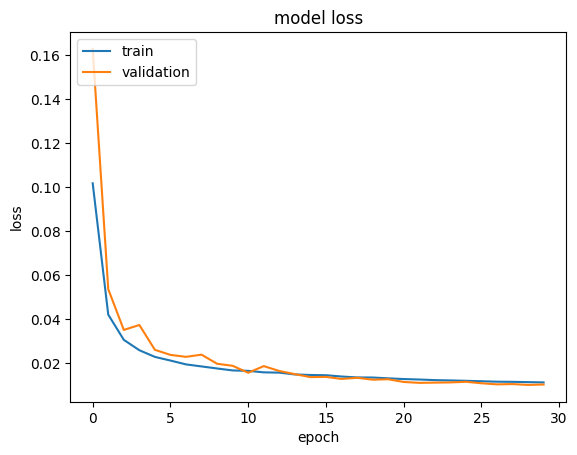

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
test_predictions = model.predict(X_test)
op_list= [e for y in test_predictions for e in y]   #predicted list
ip_list = [e for y in Y_test for e in y]    #actual list
print(len(op_list), len(ip_list))

148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
18876 18876


In [15]:
test_labels = pd.DataFrame({'actual':ip_list})
predictions = pd.DataFrame({'predict':op_list})
test_labels['actual'] = ct.named_transformers_['y'].inverse_transform(test_labels)
predictions['predict'] = ct.named_transformers_['y'].inverse_transform(predictions)

error = predictions['predict'] - test_labels['actual']
rerror = 100*(predictions['predict'] - test_labels['actual'])/test_labels['actual']

print('Mean of error in test data:', mean(error))
print('Mean of absolute error in test data:', mean(abs(error)))
print('Root of mean of squared error in test data:', mean(error**2)**0.5)
print('Standard deviation of error in test data:', stdev(error))
print("=============================================================")
print('MPE (%):', mean(rerror))
print('MAPE (%):', mean(abs(rerror)))
print('RMSPE (%):', mean(rerror**2)**0.5)
print('Deviation of error (%):', stdev(rerror))
print("=============================================================")
print('Mean of test data:', mean(test_labels['actual']))
print('Standard deviation of test data:', stdev(test_labels['actual']))
print("Coefficient of determination:",r2_score(test_labels['actual'], predictions['predict']))

Mean of error in test data: -666.597965525833
Mean of absolute error in test data: 943.8444696431646
Root of mean of squared error in test data: 1340.979695133028
Standard deviation of error in test data: 1163.5916045697725
MPE (%): -1.2115236998091017
MAPE (%): 1.8294735156023632
RMSPE (%): 2.3956211596786017
Deviation of error (%): 2.0667455947602407
Mean of test data: 47586.94406008291
Standard deviation of test data: 10122.943126756529
Coefficient of determination: 0.9824509620666504


In [16]:
#absolute errors
for threshold in [5,10,50,100,500,1000,1500,2000,3000,4000,5000]:
    accuracy = sum(abs(e) < threshold for e in error)/len(error)*100
    print('accuracy:', accuracy,'% with threshold of', threshold)

accuracy: 0.5350709896164442 % with threshold of 5
accuracy: 0.9376986649713922 % with threshold of 10
accuracy: 4.74147065056156 % with threshold of 50
accuracy: 9.196863742318289 % with threshold of 100
accuracy: 41.327611782157234 % with threshold of 500
accuracy: 66.85208730663275 % with threshold of 1000
accuracy: 80.68446704810341 % with threshold of 1500
accuracy: 87.7834286925196 % with threshold of 2000
accuracy: 94.84000847637212 % with threshold of 3000
accuracy: 98.29942784488239 % with threshold of 4000
accuracy: 99.66624284806103 % with threshold of 5000


In [17]:
#relative errors
for threshold in [0.5,1,1.5,2,3,4,5]:
    accuracy = sum(abs(e) < threshold for e in rerror)/len(error)*100
    print('accuracy:', accuracy,'% with threshold of', threshold)

accuracy: 19.00826446280992 % with threshold of 0.5
accuracy: 36.86692095783005 % with threshold of 1
accuracy: 52.16677262131808 % with threshold of 1.5
accuracy: 64.25619834710744 % with threshold of 2
accuracy: 80.78512396694215 % with threshold of 3
accuracy: 89.9607967789786 % with threshold of 4
accuracy: 95.20025429116338 % with threshold of 5


In [18]:
import matplotlib
matplotlib.rcParams.update({'font.size': 48})

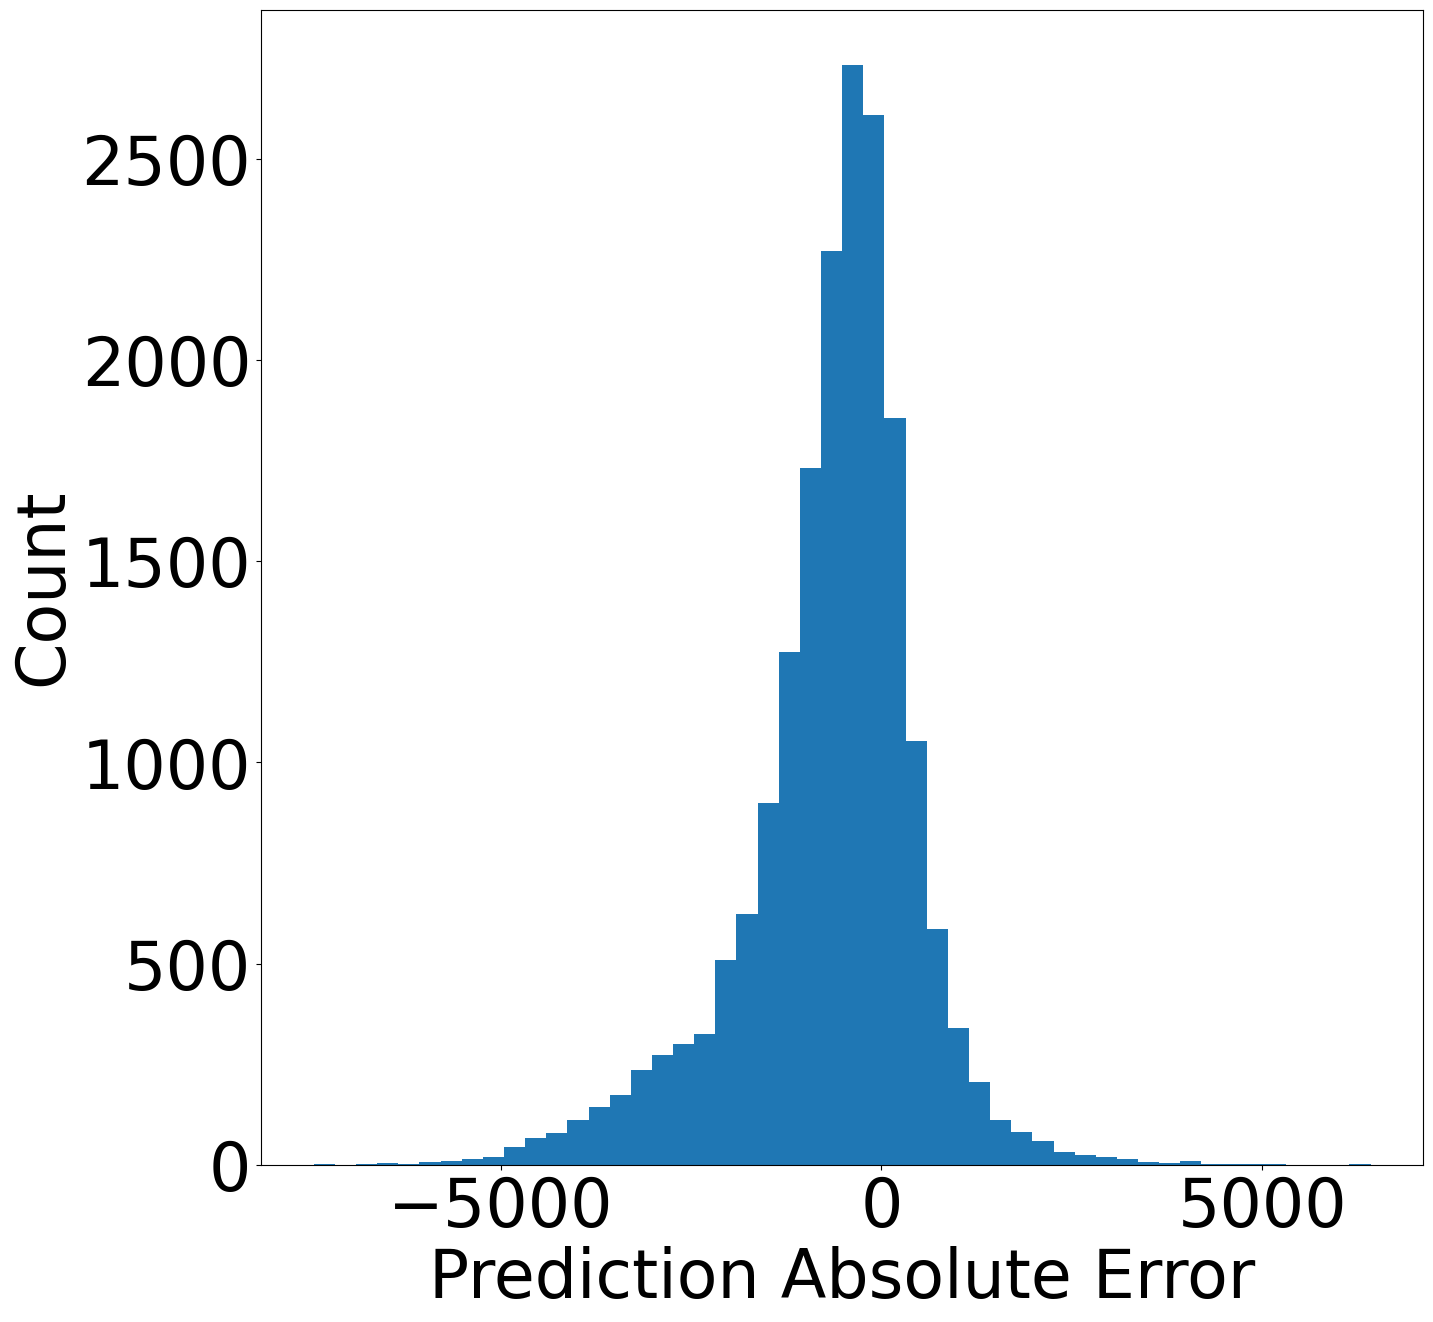

In [19]:
plt.figure(figsize=(15,15))
plt.hist(error, bins = 50)
plt.xlabel("Prediction Absolute Error")
_ = plt.ylabel("Count")

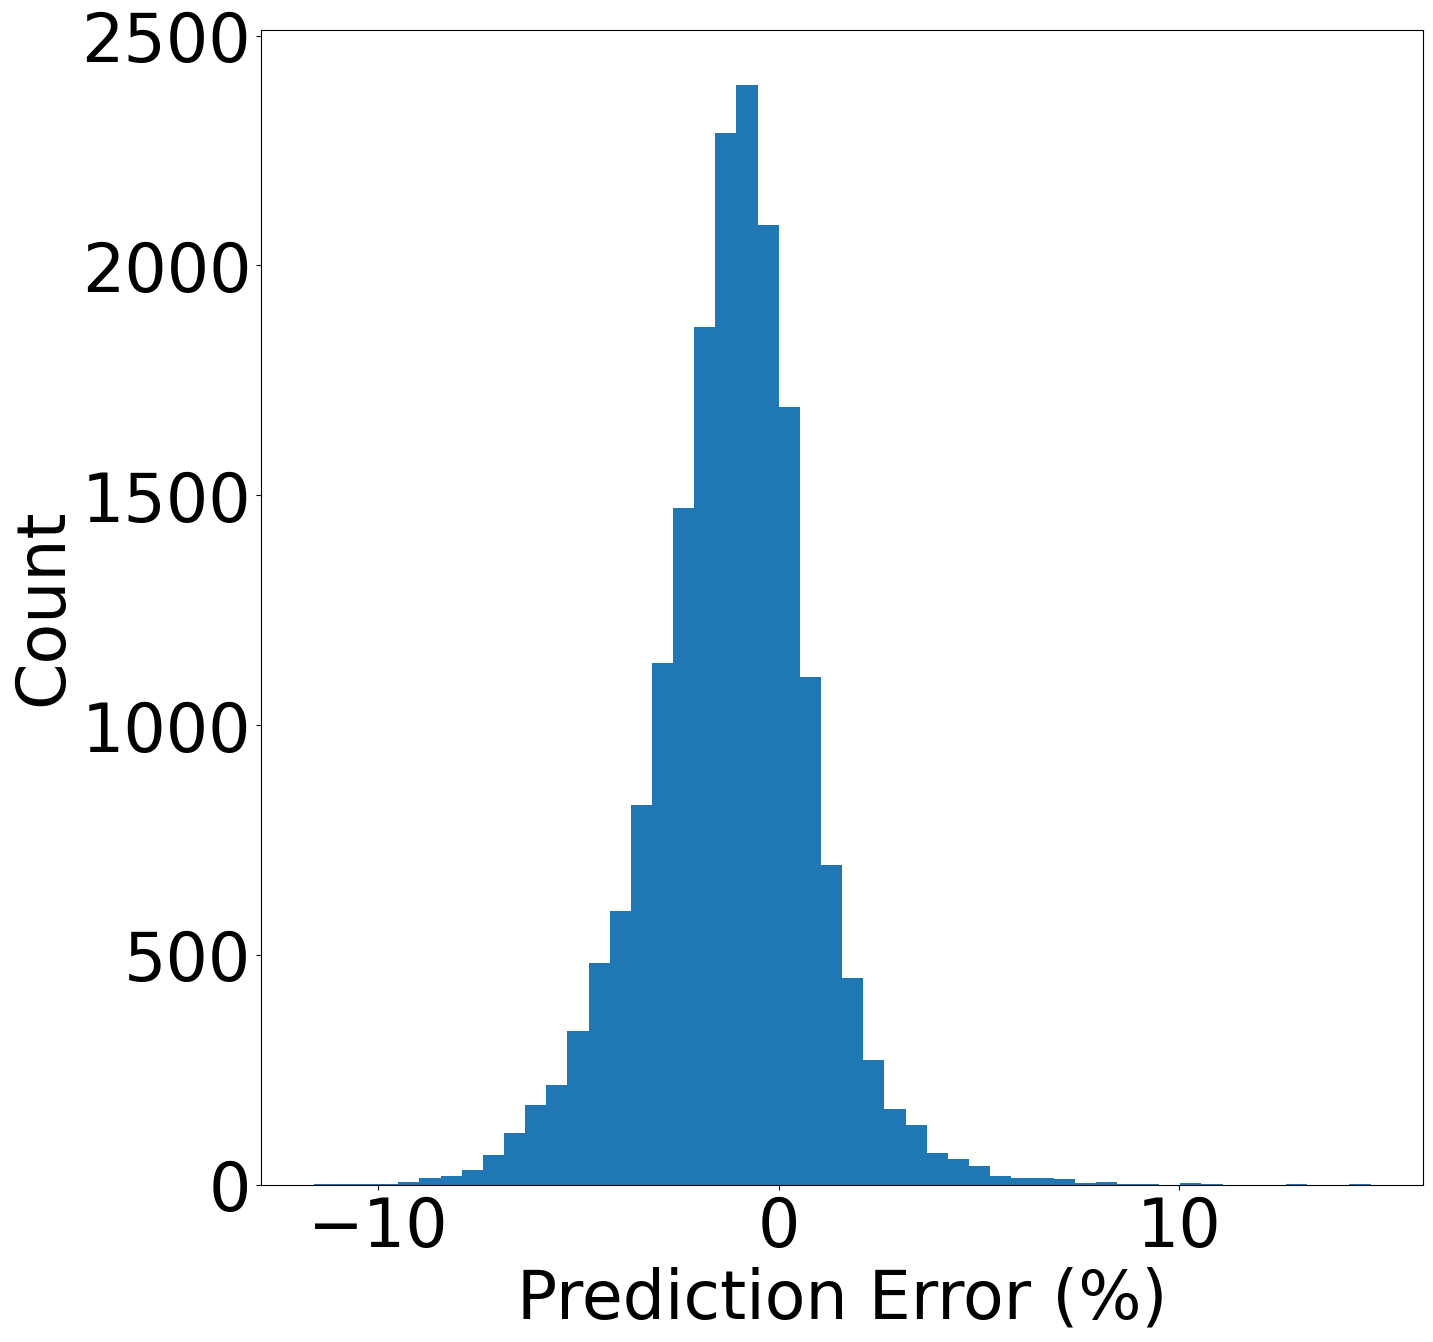

In [20]:
plt.figure(figsize=(15,15))
plt.hist(rerror, bins = 50)
plt.xlabel("Prediction Error (%)")
_ = plt.ylabel("Count")

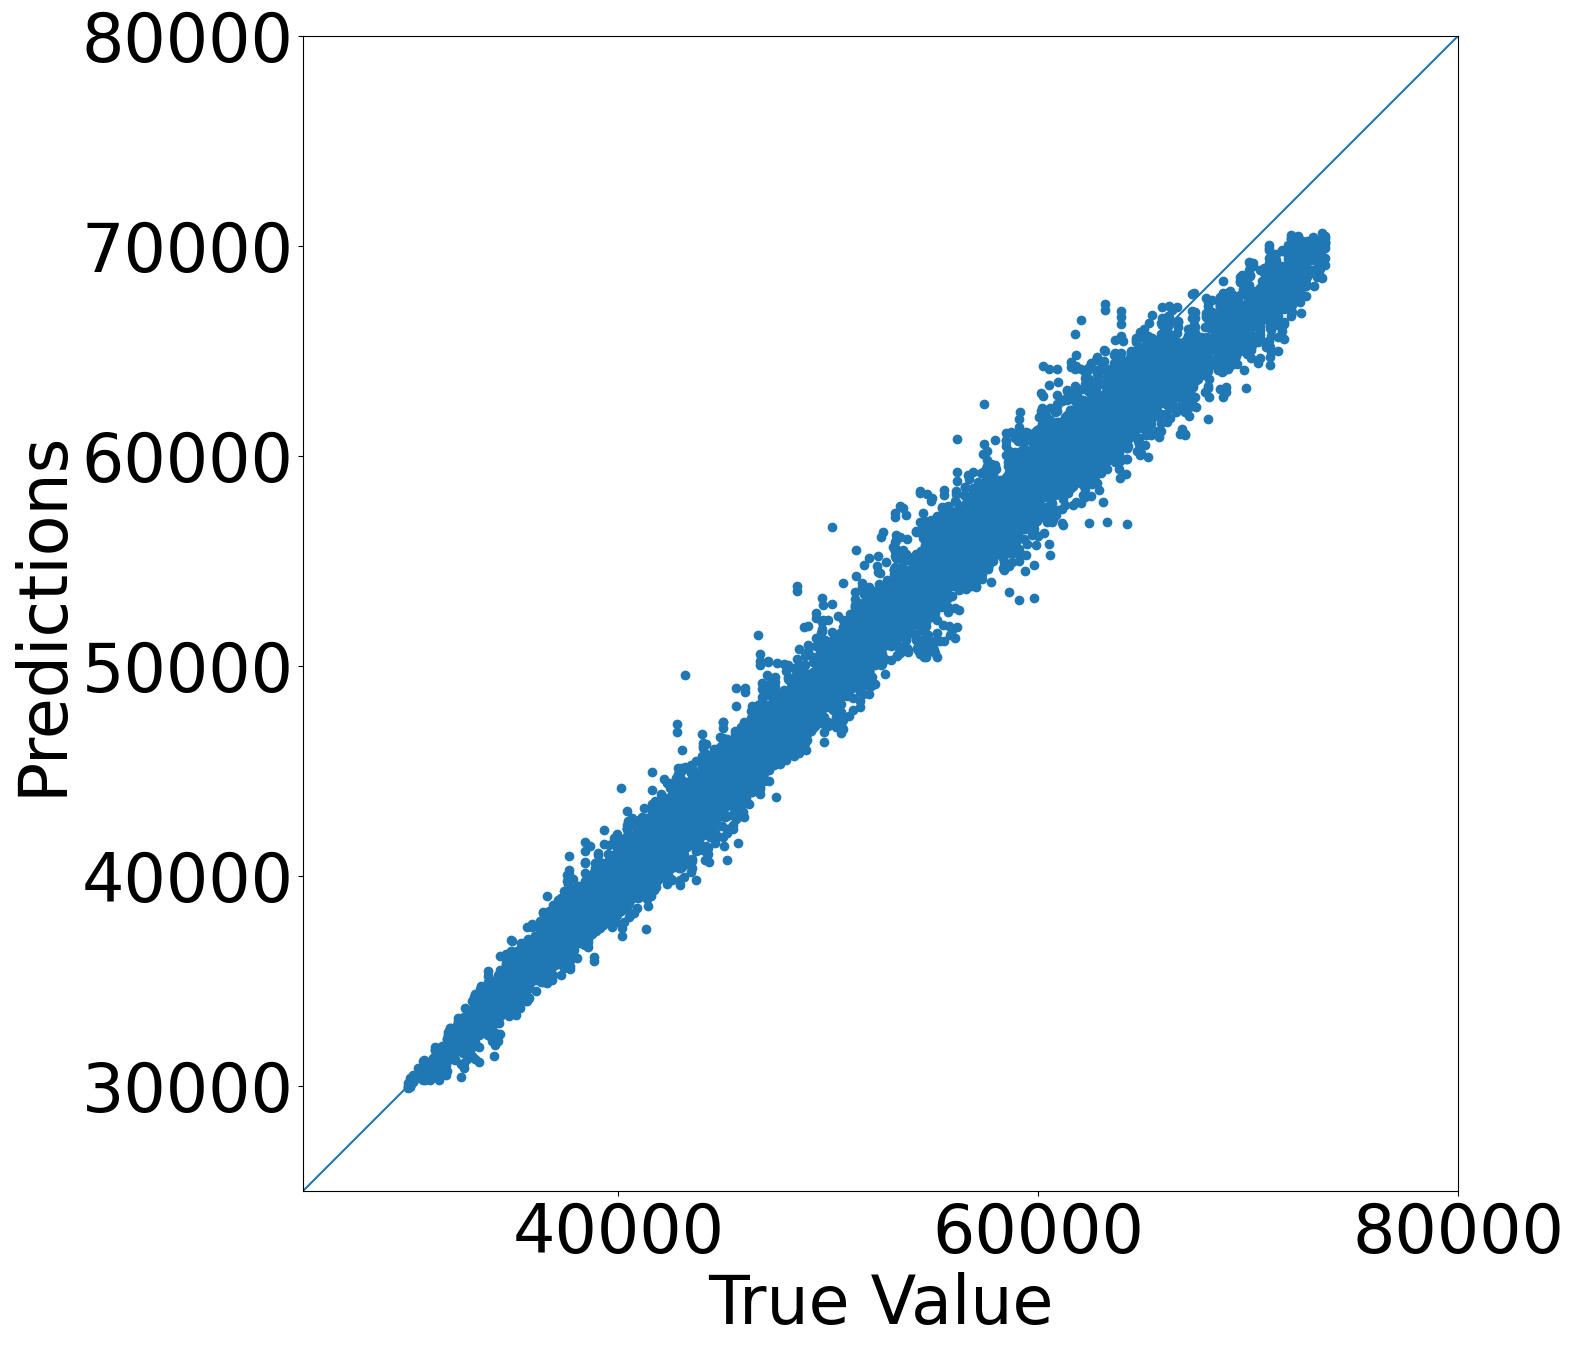

In [21]:
plt.figure(figsize=(25,15))
a = plt.axes(aspect='equal')
plt.scatter(test_labels['actual'], predictions)
plt.xlabel('True Value')
plt.ylabel('Predictions')
lims = [25000, 80000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [22]:
end = datetime.datetime.now()
print('total time:', end-start)

total time: 0:28:23.884082


In [23]:
from keras.models import save_model
save_model(model,'Models/LSTM_model_3.0.1.h5',include_optimizer=True)
np.save('Models/LSTM_history_3.0.1.npy',history.history)

In [24]:
import numpy as np
history = np.load('Models/LSTM_history_3.0.1.npy', allow_pickle=True)[()]
history


{'loss': [0.10175947099924088,
  0.042078278958797455,
  0.030625831335783005,
  0.025901107117533684,
  0.02287164330482483,
  0.02120548114180565,
  0.019466664642095566,
  0.018534155562520027,
  0.01760924980044365,
  0.016720902174711227,
  0.016525788232684135,
  0.01584564708173275,
  0.015719247981905937,
  0.014891392551362514,
  0.01465029176324606,
  0.014539788477122784,
  0.013953404501080513,
  0.013537080027163029,
  0.013500256463885307,
  0.013129817321896553,
  0.012804639525711536,
  0.012593153864145279,
  0.01232006773352623,
  0.01217238511890173,
  0.011997674591839314,
  0.011805439367890358,
  0.011601009406149387,
  0.01153307780623436,
  0.011405372060835361,
  0.011274549178779125],
 'mae': [0.2369910478591919,
  0.1553177833557129,
  0.13128447532653809,
  0.12013863027095795,
  0.11311628669500351,
  0.10854583978652954,
  0.10390439629554749,
  0.10138004273176193,
  0.09874481707811356,
  0.09645705670118332,
  0.09557882696390152,
  0.09374095499515533,

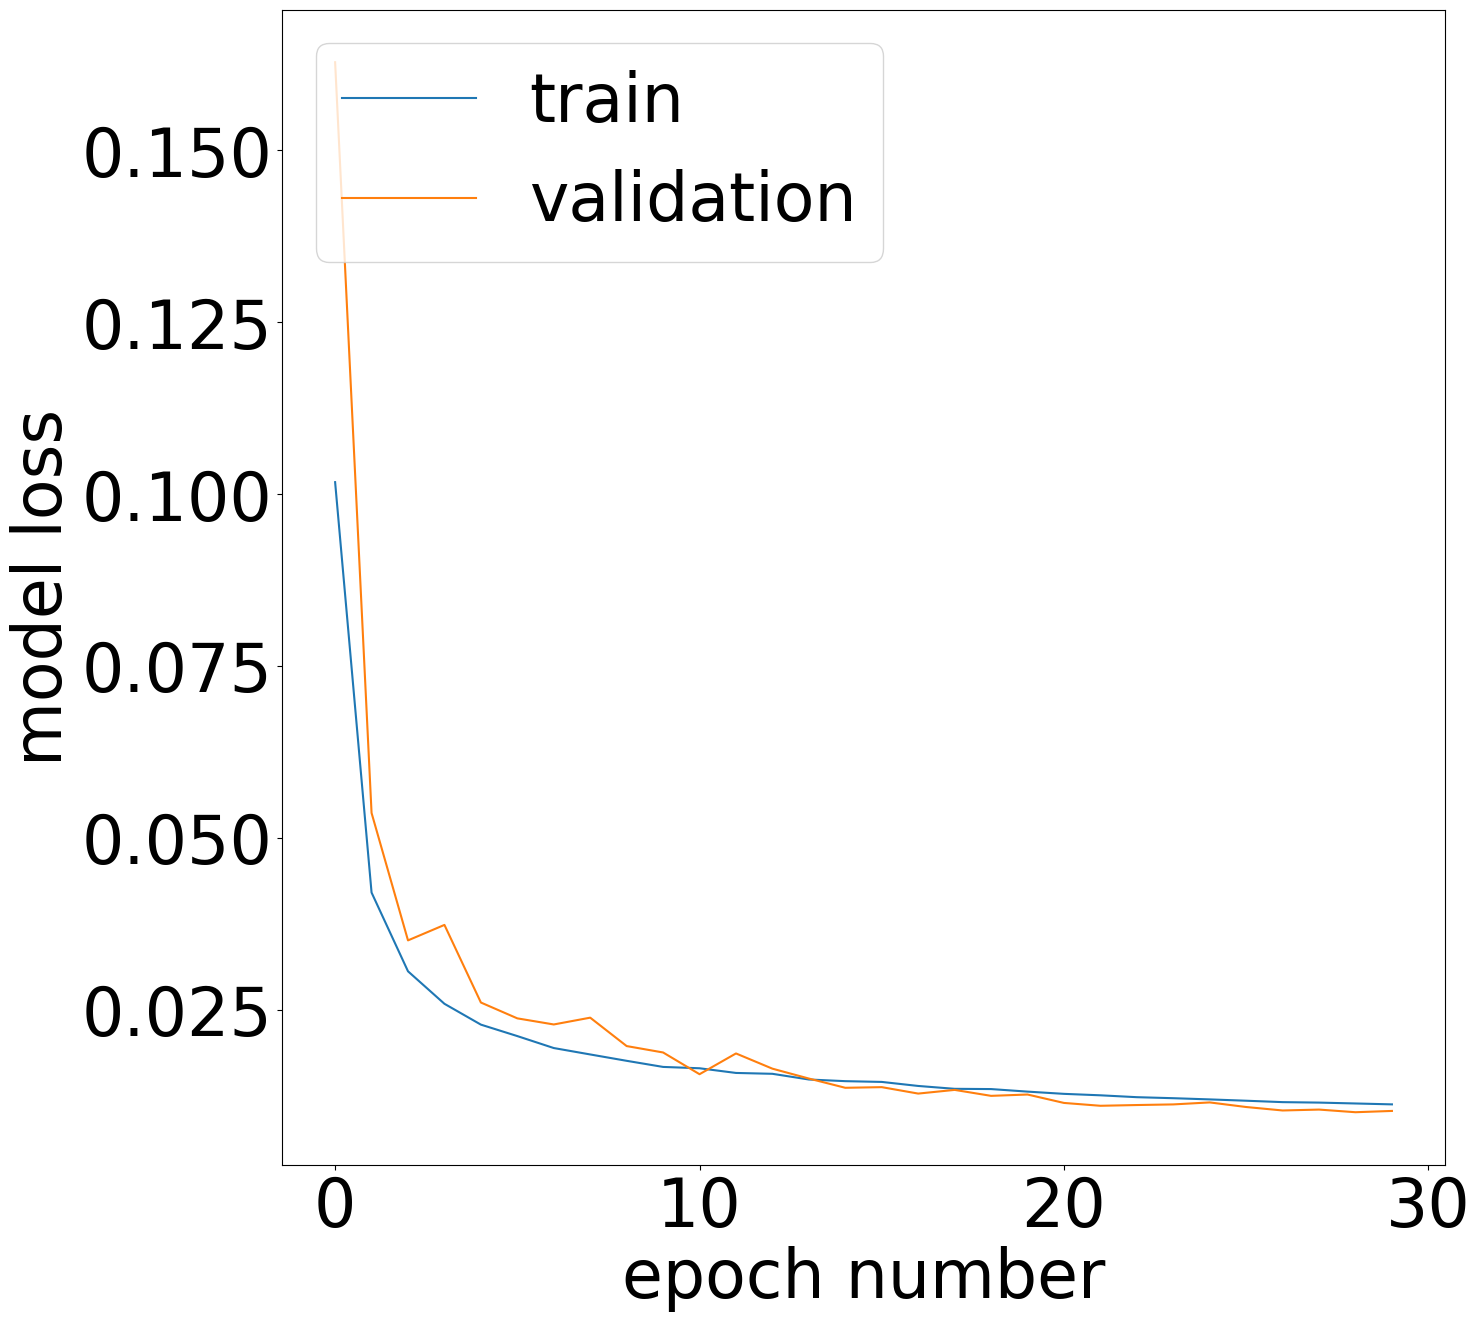

In [25]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 48})

plt.figure(figsize=(15,15))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
# plt.title('model loss')
plt.ylabel('model loss')
plt.xlabel('epoch number')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [26]:
from keras.models import load_model
custom_objects = {'mse': 'mean_squared_error'}
model = load_model('Models/LSTM_model_3.0.1.h5', custom_objects=custom_objects)

#model = load_model('Models/LSTM_model_3.0.1.h5')

In [27]:
np.save('Models/predictions1.0', np.array(predictions['predict']))